# MNIST

In [189]:
import time

import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import torch

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from turbanet import TurbaTrainState

In [190]:
EPOCHS = 10
SWARM_SIZE = 5
BATCH_SIZE = 32
LR = 5e-5

In [191]:
HIDDEN1 = 64
HIDDEN2 = 32

## Data Collection

In [192]:
train_df = pd.read_csv("../../data/input/train.csv")
test_df = pd.read_csv("../../data/input/test.csv")
print(train_df.shape, test_df.shape)
print("Train Cols : ", train_df.columns)
print("Test Cols : ", test_df.columns)
print(" Label -  ", [i for i in train_df.columns if i not in test_df.columns])

(42000, 785) (28000, 784)
Train Cols :  Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
Test Cols :  Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)
 Label -   ['label']


In [193]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
train_df["label"].value_counts().sort_index()

label
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: count, dtype: int64

In [195]:
# Convert df to numpy array
images = np.array(train_df.iloc[:, 1:])

In [196]:
images.shape

(42000, 784)

In [197]:
# Scaling the image so that the values only range between 0 and 1
images = images / 255.0

In [198]:
# Convert labels to one-hot encoding tensor
labels = np.array(train_df["label"])  # .reshape(-1,1)
labels.shape

(42000,)

In [199]:
image_label = np.zeros((images.shape[0], 10))
image_label[np.arange(images.shape[0]), labels] = 1.0

In [200]:
X_train, X_val, y_train, y_val = train_test_split(
    images, image_label, test_size=0.2, stratify=train_df["label"]
)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5)

In [201]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(33600, 784)
(33600, 10)
(4200, 784)
(4200, 10)
(4200, 784)
(4200, 10)


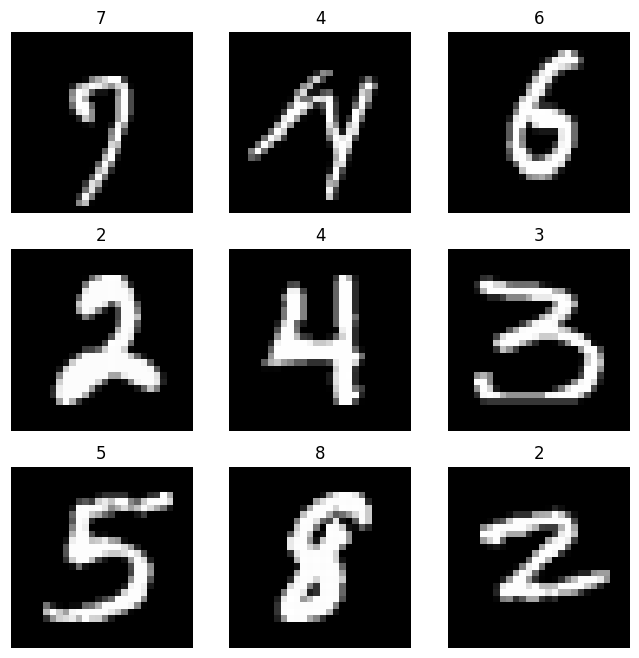

In [202]:
# Ploting some of the datapoints in the dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
figure.add_subplot(rows, cols, 1)
plt.axis("off")
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(X_train), size=(1,)).item()
    sample_img = X_train[sample_idx].reshape(28, 28)
    sample_lbl = np.argmax(y_train[sample_idx])
    figure.add_subplot(rows, cols, i)
    plt.title(sample_lbl)
    plt.axis("off")
    plt.imshow(sample_img.squeeze(), cmap="gray")
plt.show()

In [203]:
# Generate batches of data
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

train_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False
)
test_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=True
)


## Turbanet

In [204]:
from flax import linen as nn


# Softmax layer ignored since the loss function defined is nn.CrossEntropy()
class Brain(nn.Module):
    @nn.compact
    def __call__(self, x):  # noqa ANN001
        x = nn.Dense(HIDDEN1)(x)
        x = nn.relu(x)
        x = nn.Dense(HIDDEN2)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)

        return x


In [205]:
from turbanet import softmax_cross_entropy


def turbanet_train(dataloader, model: TurbaTrainState):
    size = 0
    correct = 0

    batch_loss = np.zeros(len(dataloader))
    batch_accuracy = np.zeros(len(dataloader))

    for batch, (X, y) in enumerate(dataloader):
        # Repeat for swarm_size times
        X = np.expand_dims(X.numpy(), 0).repeat(len(model), axis=0)
        y = np.expand_dims(y.numpy(), 0).repeat(len(model), axis=0)

        # Feedforward / Loss
        model, loss, prediction = model.train(X, y, softmax_cross_entropy)

        # Accuracy
        _correct = (prediction.argmax(axis=2) == y.argmax(axis=2)).astype(float).sum(axis=1)

        # Updating loss_batch and batch_accuracy
        batch_loss[batch] = loss.mean().item()
        batch_accuracy[batch] = (_correct / dataloader.batch_size).mean().item()

        # Updating size and correct
        size += dataloader.batch_size
        correct += _correct

        if batch % 100 == 0:
            loss = loss.mean().item()
            current = batch * dataloader.batch_size
            print(f"loss: {loss:>7f}  [{current:>5d}]")

    accuracy = (correct / size).mean().item()
    print(f"Train Accuracy: {(100 * accuracy):>0.1f}%")

    return model, batch_loss, batch_accuracy


In [206]:
def turbanet_validation(dataloader, model):
    size = 0
    correct = 0

    batch_loss = np.zeros(len(dataloader))
    batch_accuracy = np.zeros(len(dataloader))
    for batch, (X, y) in enumerate(dataloader):
        # Repeat for swarm_size times
        X = np.expand_dims(X.numpy(), 0).repeat(len(model), axis=0)
        y = np.expand_dims(y.numpy(), 0).repeat(len(model), axis=0)

        # Feedforward / Loss
        loss, prediction = model.evaluate(X, y, softmax_cross_entropy)

        # Accuracy
        _correct = (prediction.argmax(axis=2) == y.argmax(axis=2)).astype(float).sum(axis=1)

        # Updating loss_batch and batch_accuracy
        batch_loss[batch] = loss.mean().item()
        batch_accuracy[batch] = (_correct / dataloader.batch_size).mean().item()

        # Updating size and correct
        size += dataloader.batch_size
        correct += _correct

    accuracy = (correct / size).mean().item()
    print(f"Validation Accuracy: {(100 * accuracy):>0.1f}%")

    return batch_loss, batch_accuracy

In [207]:
optimizer = optax.adam(learning_rate=LR)

In [208]:
model = TurbaTrainState.swarm(Brain(), optimizer, swarm_size=SWARM_SIZE, sample_input=X_train[0])

In [209]:
start = time.time()
train_batch_loss = []
train_batch_accuracy = []
valid_batch_accuracy = []
valid_batch_loss = []
train_epoch_no = []
valid_epoch_no = []

for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    model, _train_batch_loss, _train_batch_accuracy = turbanet_train(train_dataloader, model)
    _valid_batch_loss, _valid_batch_accuracy = turbanet_validation(val_dataloader, model)

    for i in range(len(_train_batch_loss)):
        train_batch_loss.append(_train_batch_loss[i])
        train_batch_accuracy.append(_train_batch_accuracy[i])
        train_epoch_no.append(t + float((i + 1) / len(_train_batch_loss)))

    for i in range(len(_valid_batch_loss)):
        valid_batch_loss.append(_valid_batch_loss[i])
        valid_batch_accuracy.append(_valid_batch_accuracy[i])
        valid_epoch_no.append(t + float((i + 1) / len(_valid_batch_loss)))

print(f"turba time: {time.time() - start}")

Epoch 1
-------------------------------
loss: 2.311183  [    0]
loss: 2.200287  [ 3200]
loss: 2.036081  [ 6400]
loss: 1.897294  [ 9600]
loss: 1.666008  [12800]
loss: 1.366120  [16000]
loss: 1.198877  [19200]
loss: 1.055096  [22400]
loss: 1.152911  [25600]
loss: 0.803525  [28800]
loss: 0.907738  [32000]
Train Accuracy: 63.9%
Validation Accuracy: 82.6%
Epoch 2
-------------------------------
loss: 0.568895  [    0]
loss: 0.670180  [ 3200]
loss: 0.924852  [ 6400]
loss: 0.577908  [ 9600]
loss: 0.678947  [12800]
loss: 0.425864  [16000]
loss: 0.606709  [19200]
loss: 0.430995  [22400]
loss: 0.317287  [25600]
loss: 0.548390  [28800]
loss: 0.448935  [32000]
Train Accuracy: 86.3%
Validation Accuracy: 87.8%
Epoch 3
-------------------------------
loss: 0.371501  [    0]
loss: 0.485948  [ 3200]
loss: 0.465734  [ 6400]
loss: 0.440946  [ 9600]
loss: 0.467846  [12800]
loss: 0.181025  [16000]
loss: 0.270985  [19200]
loss: 0.385569  [22400]
loss: 0.463698  [25600]
loss: 0.490757  [28800]
loss: 0.283606

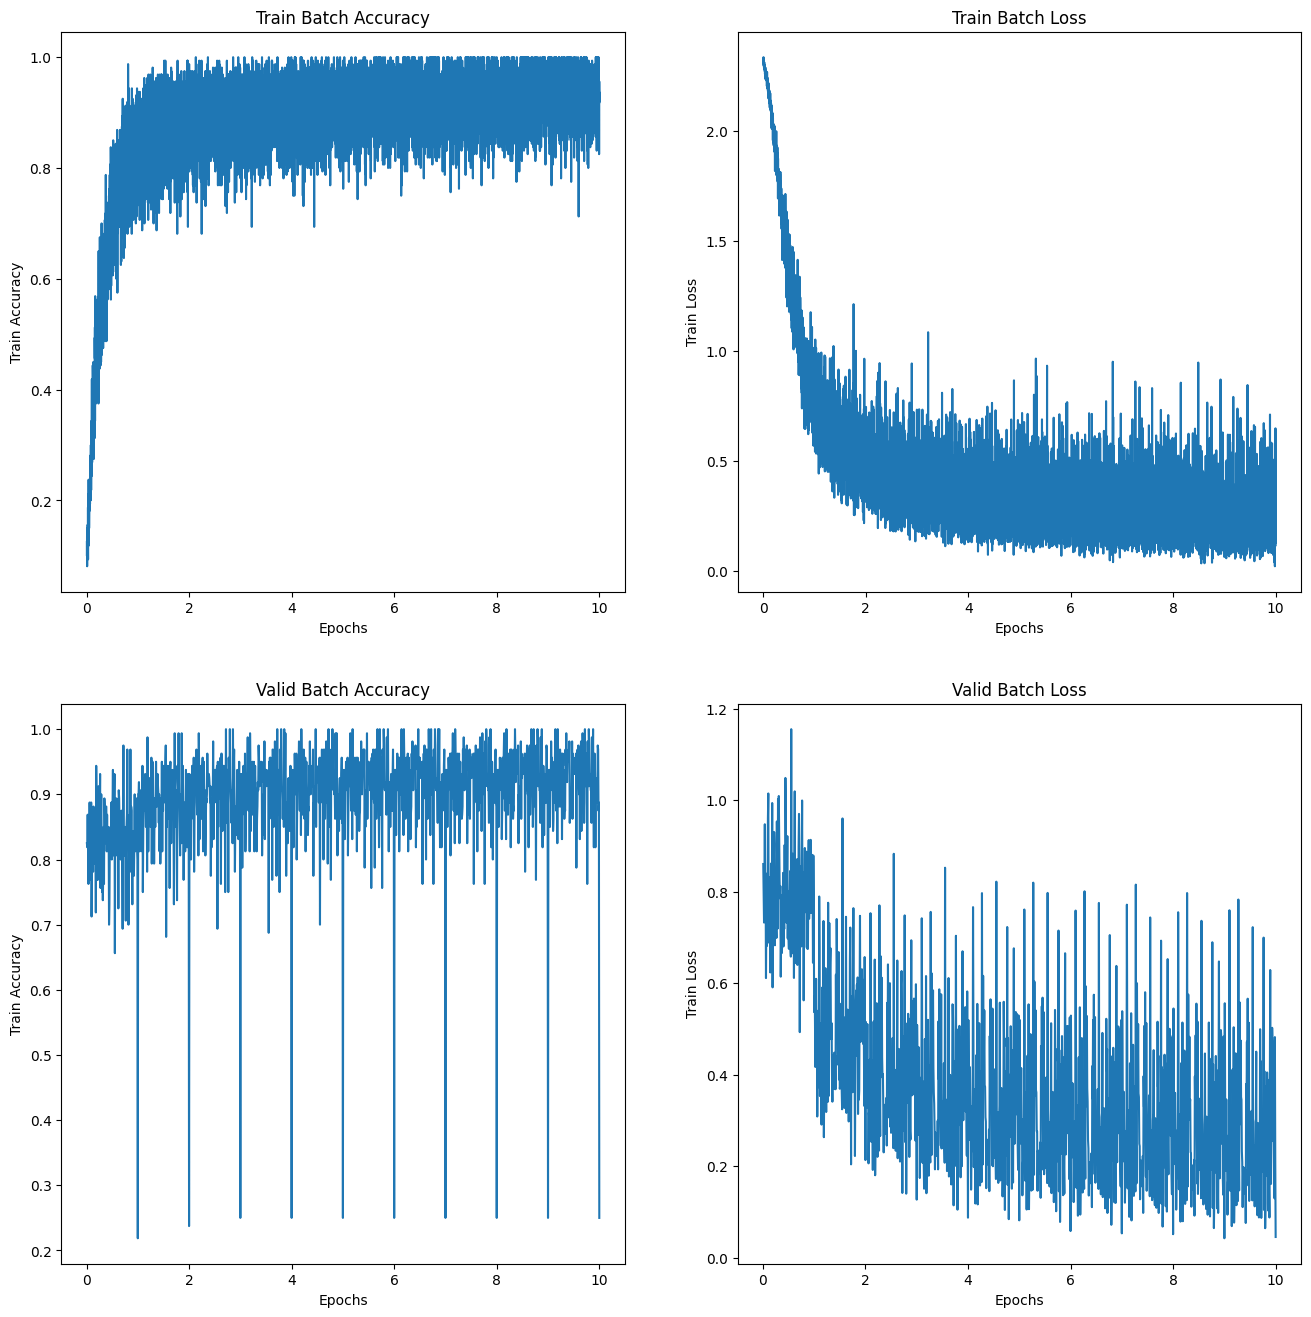

In [210]:
figure = plt.figure(figsize=(16, 16))


figure.add_subplot(2, 2, 1)
plt.plot(train_epoch_no, train_batch_accuracy)
plt.title("Train Batch Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")

figure.add_subplot(2, 2, 2)
plt.plot(train_epoch_no, train_batch_loss)
plt.title("Train Batch Loss")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

figure.add_subplot(2, 2, 3)
plt.plot(valid_epoch_no, valid_batch_accuracy)
plt.title("Valid Batch Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")

figure.add_subplot(2, 2, 4)
plt.plot(valid_epoch_no, valid_batch_loss)
plt.title("Valid Batch Loss")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")


plt.show()

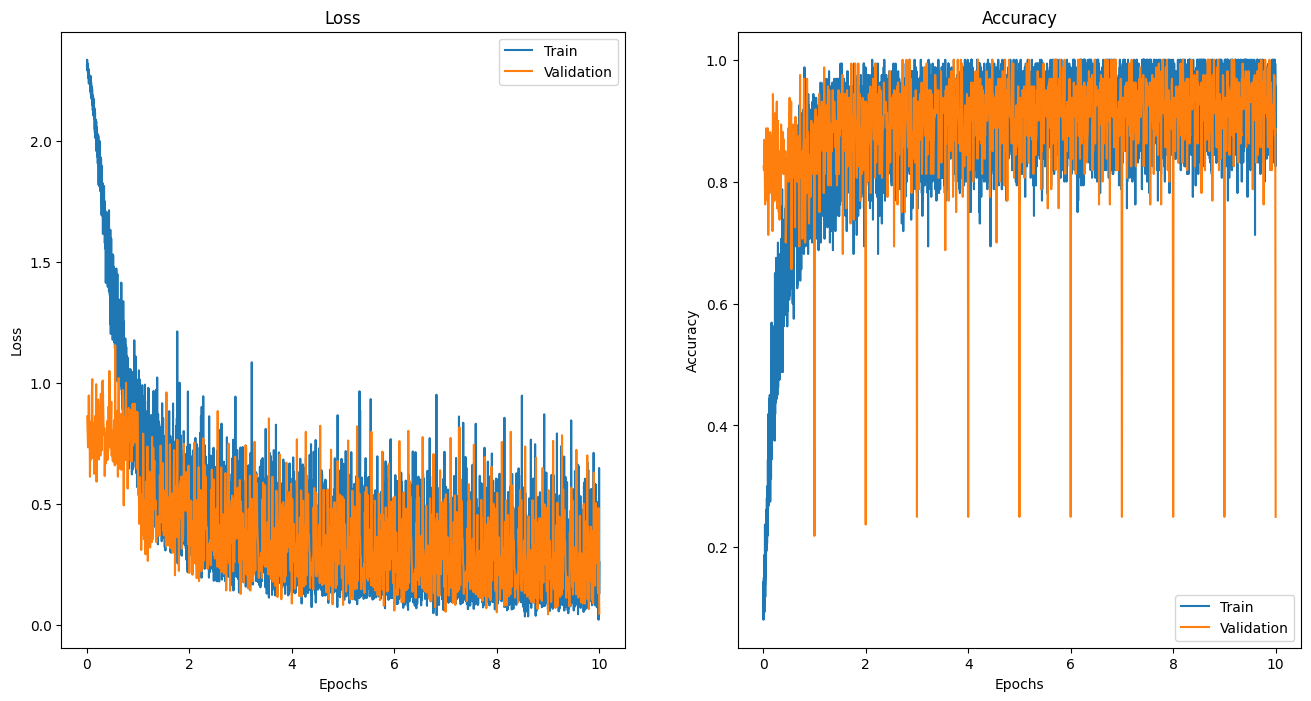

In [211]:
# Plot training and validation loss together
figure = plt.figure(figsize=(16, 8))

figure.add_subplot(1, 2, 1)
plt.plot(train_epoch_no, train_batch_loss)
plt.plot(valid_epoch_no, valid_batch_loss)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])

figure.add_subplot(1, 2, 2)
plt.plot(train_epoch_no, train_batch_accuracy)
plt.plot(valid_epoch_no, valid_batch_accuracy)
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])

plt.show()


In [212]:
# Run on test set
y_pred = np.empty((SWARM_SIZE, 0))
y_true = np.empty((SWARM_SIZE, 0))
for X, y in test_dataloader:
    X = np.expand_dims(X.numpy(), 0).repeat(len(model), axis=0)
    y = np.expand_dims(y.numpy(), 0).repeat(len(model), axis=0)

    prediction = np.argmax(model.predict(X), axis=2)
    truth = np.argmax(y, axis=2)

    y_pred = np.append(y_pred, prediction, axis=1)
    y_true = np.append(y_true, truth, axis=1)

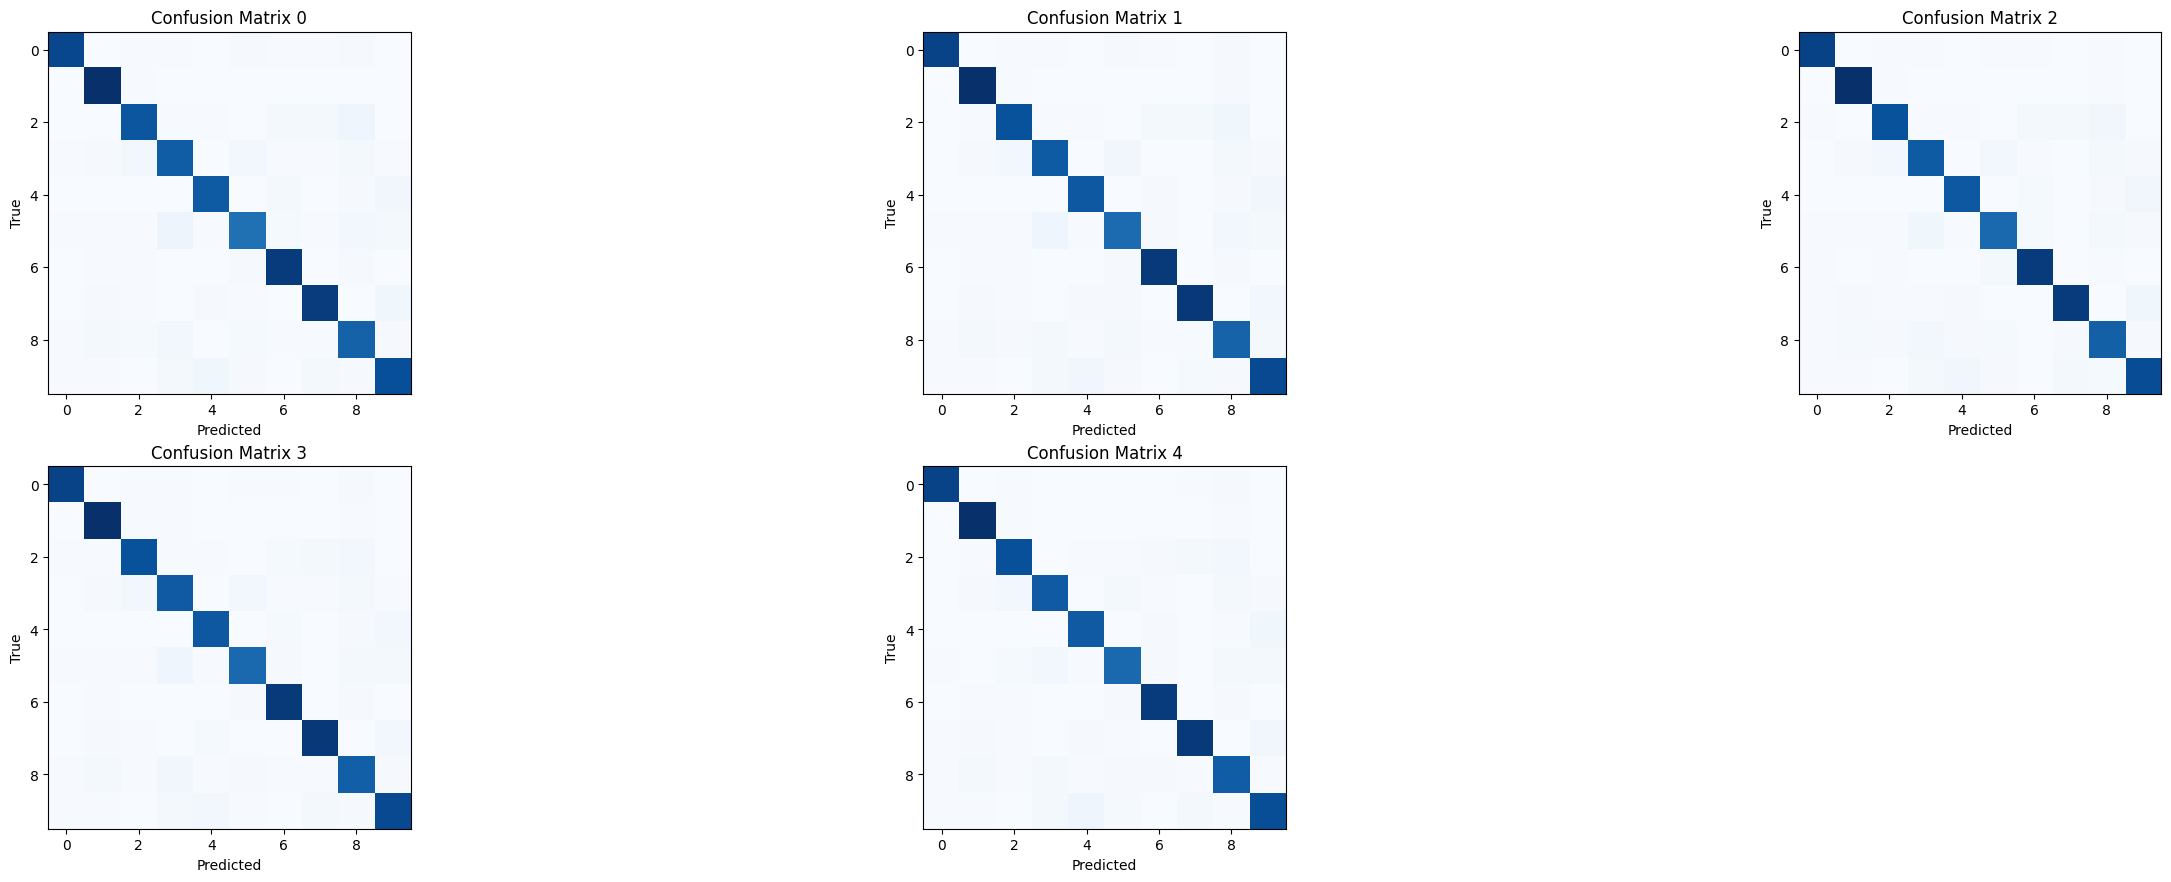

In [213]:
# Subplot of predictions vs ground truth (x by x)
fig = plt.figure(figsize=(32, 16))

# Shared axes
for i in range(SWARM_SIZE):
    ax = fig.add_subplot(
        int(np.ceil(np.sqrt(SWARM_SIZE))), int(np.ceil(np.sqrt(SWARM_SIZE))), i + 1
    )

    # Confusion matrix
    cm = confusion_matrix(y_true[i], y_pred[i], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)

    # Labels
    ax.set_title(f"Confusion Matrix {i}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.show()

## Torch

In [214]:
## Checking if the GPU is being used properly.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [215]:
from torch import nn


# Softmax layer ignored since the loss function defined is nn.CrossEntropy()
class MyOwnNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyOwnNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, HIDDEN1),
            nn.ReLU(),
            nn.Linear(HIDDEN1, HIDDEN2),
            nn.ReLU(),
            nn.Linear(HIDDEN2, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = MyOwnNeuralNetwork().to(device)
print(model)

model = model.cuda()
torch.backends.cudnn.benchmark = True
torch.cuda.set_device(0)

MyOwnNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [216]:
## Defining optimizer and loss functions
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [217]:
def pytorch_train(dataloader, model, loss_fn, optimizer):
    model.train()

    size = 0
    correct = 0

    batch_loss = np.zeros(len(dataloader))
    batch_accuracy = np.zeros(len(dataloader))

    for batch, (X, y) in enumerate(dataloader):
        # Feedforward / Loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy
        _correct = (pred.argmax(1) == y.argmax(1)).type(torch.float32).sum().item()

        # Updating loss_batch and batch_accuracy
        batch_loss[batch] = loss.item()
        batch_accuracy[batch] = _correct / X.shape[0]

        # Updating size and correct
        size += X.shape[0]
        correct += _correct

        if batch % 100 == 0:
            loss = loss.item()
            current = batch * X.shape[0]
            print(f"loss: {loss:>7f}  [{current:>5d}]")

    accuracy = correct / size
    print(f"Train Accuracy: {(100 * accuracy):>0.1f}%")

    return batch_loss, batch_accuracy


In [218]:
def pytorch_validation(dataloader, model, loss_fn):
    model.eval()

    size = 0
    correct = 0

    batch_loss = np.zeros(len(dataloader))
    batch_accuracy = np.zeros(len(dataloader))
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            # Feedforward / Loss
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            # Accuracy
            _correct = (pred.argmax(1) == y.argmax(1)).type(torch.float32).sum().item()

            # Updating loss_batch and batch_accuracy
            batch_loss[batch] = loss.item()
            batch_accuracy[batch] = _correct / X.shape[0]

            # Updating size and correct
            size += X.shape[0]
            correct += _correct

    accuracy = correct / size
    print(f"Validation Accuracy: {(100 * accuracy):>0.1f}%")

    return batch_loss, batch_accuracy

In [219]:
# Batch the data
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [220]:
start = time.time()
train_batch_loss = []
train_batch_accuracy = []
valid_batch_accuracy = []
valid_batch_loss = []
train_epoch_no = []
valid_epoch_no = []

for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    _train_batch_loss, _train_batch_accuracy = pytorch_train(
        train_dataloader, model, loss_fn, optimizer
    )
    _valid_batch_loss, _valid_batch_accuracy = pytorch_validation(val_dataloader, model, loss_fn)

    for i in range(len(_train_batch_loss)):
        train_batch_loss.append(_train_batch_loss[i])
        train_batch_accuracy.append(_train_batch_accuracy[i])
        train_epoch_no.append(t + float((i + 1) / len(_train_batch_loss)))

    for i in range(len(_valid_batch_loss)):
        valid_batch_loss.append(_valid_batch_loss[i])
        valid_batch_accuracy.append(_valid_batch_accuracy[i])
        valid_epoch_no.append(t + float((i + 1) / len(_valid_batch_loss)))

print(f"torch time: {time.time() - start}")

Epoch 1
-------------------------------
loss: 2.322369  [    0]
loss: 2.277985  [ 3200]
loss: 2.197250  [ 6400]
loss: 2.028725  [ 9600]
loss: 1.885729  [12800]
loss: 1.627584  [16000]
loss: 1.601638  [19200]
loss: 1.346549  [22400]
loss: 1.175846  [25600]
loss: 1.148587  [28800]
loss: 1.264383  [32000]
Train Accuracy: 56.1%
Validation Accuracy: 80.9%
Epoch 2
-------------------------------
loss: 0.986322  [    0]
loss: 0.811639  [ 3200]
loss: 0.890755  [ 6400]
loss: 0.600333  [ 9600]
loss: 0.783261  [12800]
loss: 0.752337  [16000]
loss: 0.549006  [19200]
loss: 0.765712  [22400]
loss: 0.521020  [25600]
loss: 0.652414  [28800]
loss: 0.509764  [32000]
Train Accuracy: 83.9%
Validation Accuracy: 86.2%
Epoch 3
-------------------------------
loss: 0.590417  [    0]
loss: 0.577368  [ 3200]
loss: 0.478529  [ 6400]
loss: 0.463341  [ 9600]
loss: 0.557569  [12800]
loss: 0.383027  [16000]
loss: 0.367124  [19200]
loss: 0.433585  [22400]
loss: 0.323695  [25600]
loss: 0.458874  [28800]
loss: 0.382930

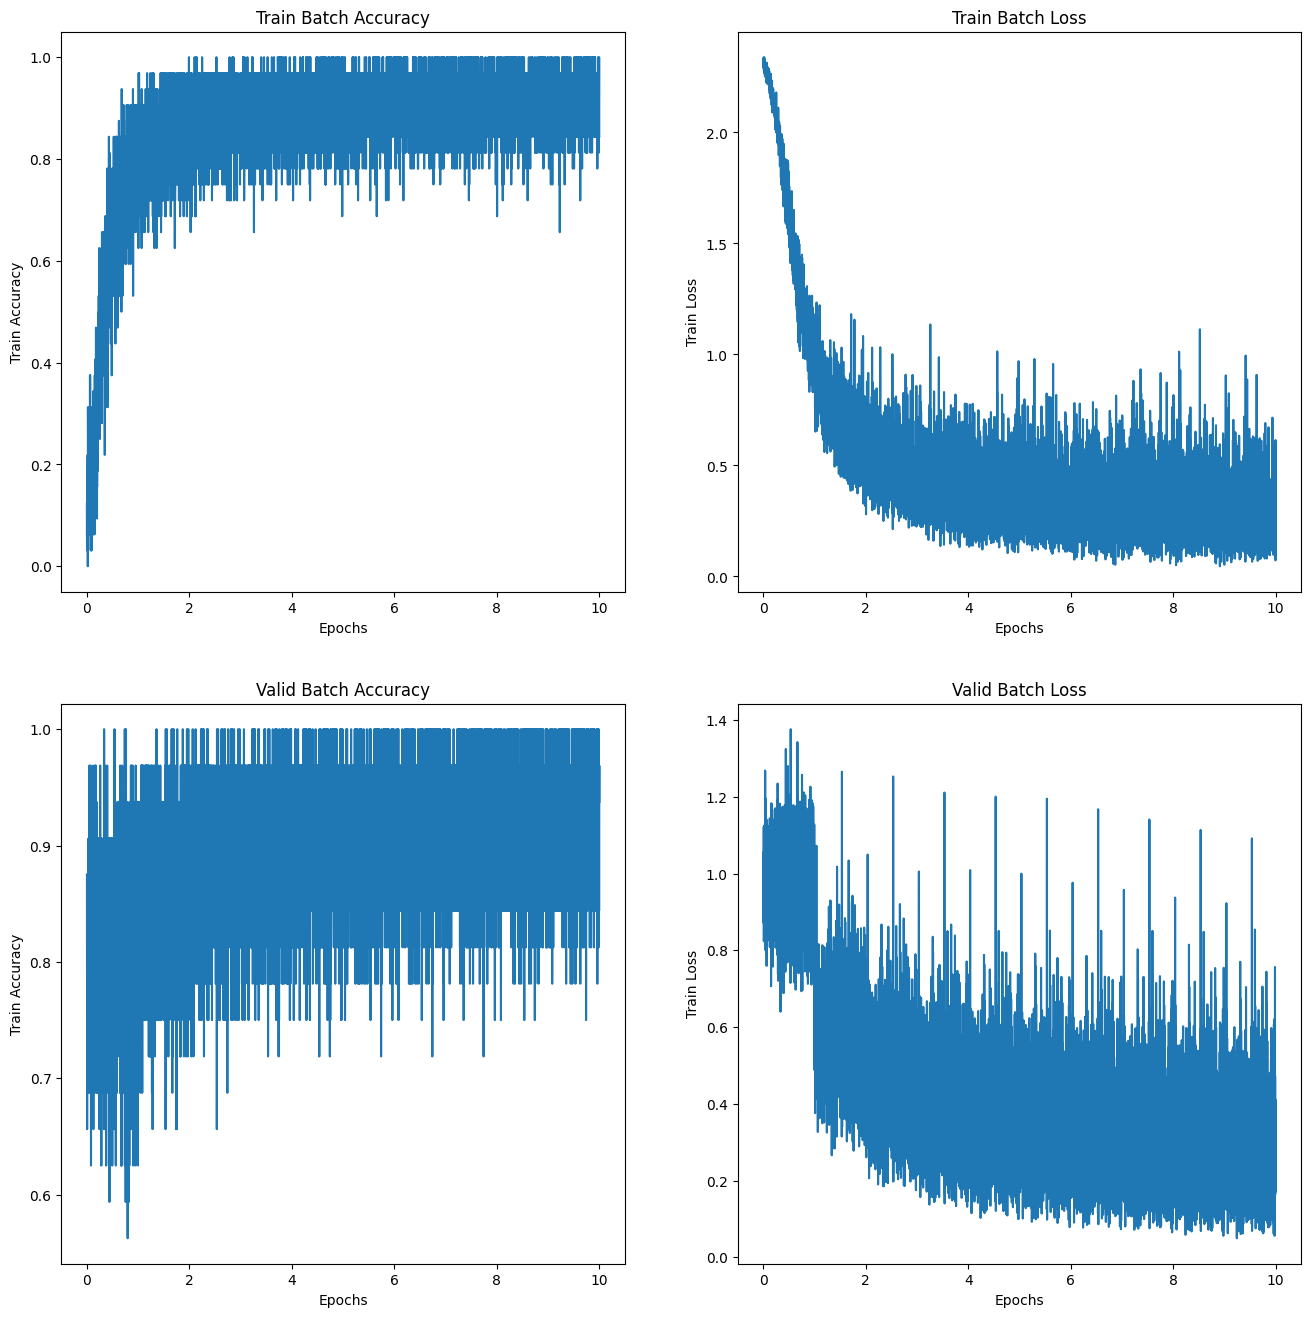

In [221]:
figure = plt.figure(figsize=(16, 16))


figure.add_subplot(2, 2, 1)
plt.plot(train_epoch_no, train_batch_accuracy)
plt.title("Train Batch Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")

figure.add_subplot(2, 2, 2)
plt.plot(train_epoch_no, train_batch_loss)
plt.title("Train Batch Loss")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

figure.add_subplot(2, 2, 3)
plt.plot(valid_epoch_no, valid_batch_accuracy)
plt.title("Valid Batch Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")

figure.add_subplot(2, 2, 4)
plt.plot(valid_epoch_no, valid_batch_loss)
plt.title("Valid Batch Loss")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")


plt.show()

In [222]:
# Run on test set
y_pred = np.empty((0, 1))
y_true = np.empty((0, 1))
for batch, (X, y) in enumerate(test_dataloader):
    X, y = X.to(device), y.to(device)
    pred = model(X)
    y_pred = np.append(y_pred, pred.argmax(1).cpu().numpy().reshape(-1, 1), axis=0)
    y_true = np.append(y_true, y.argmax(1).cpu().numpy().reshape(-1, 1), axis=0)

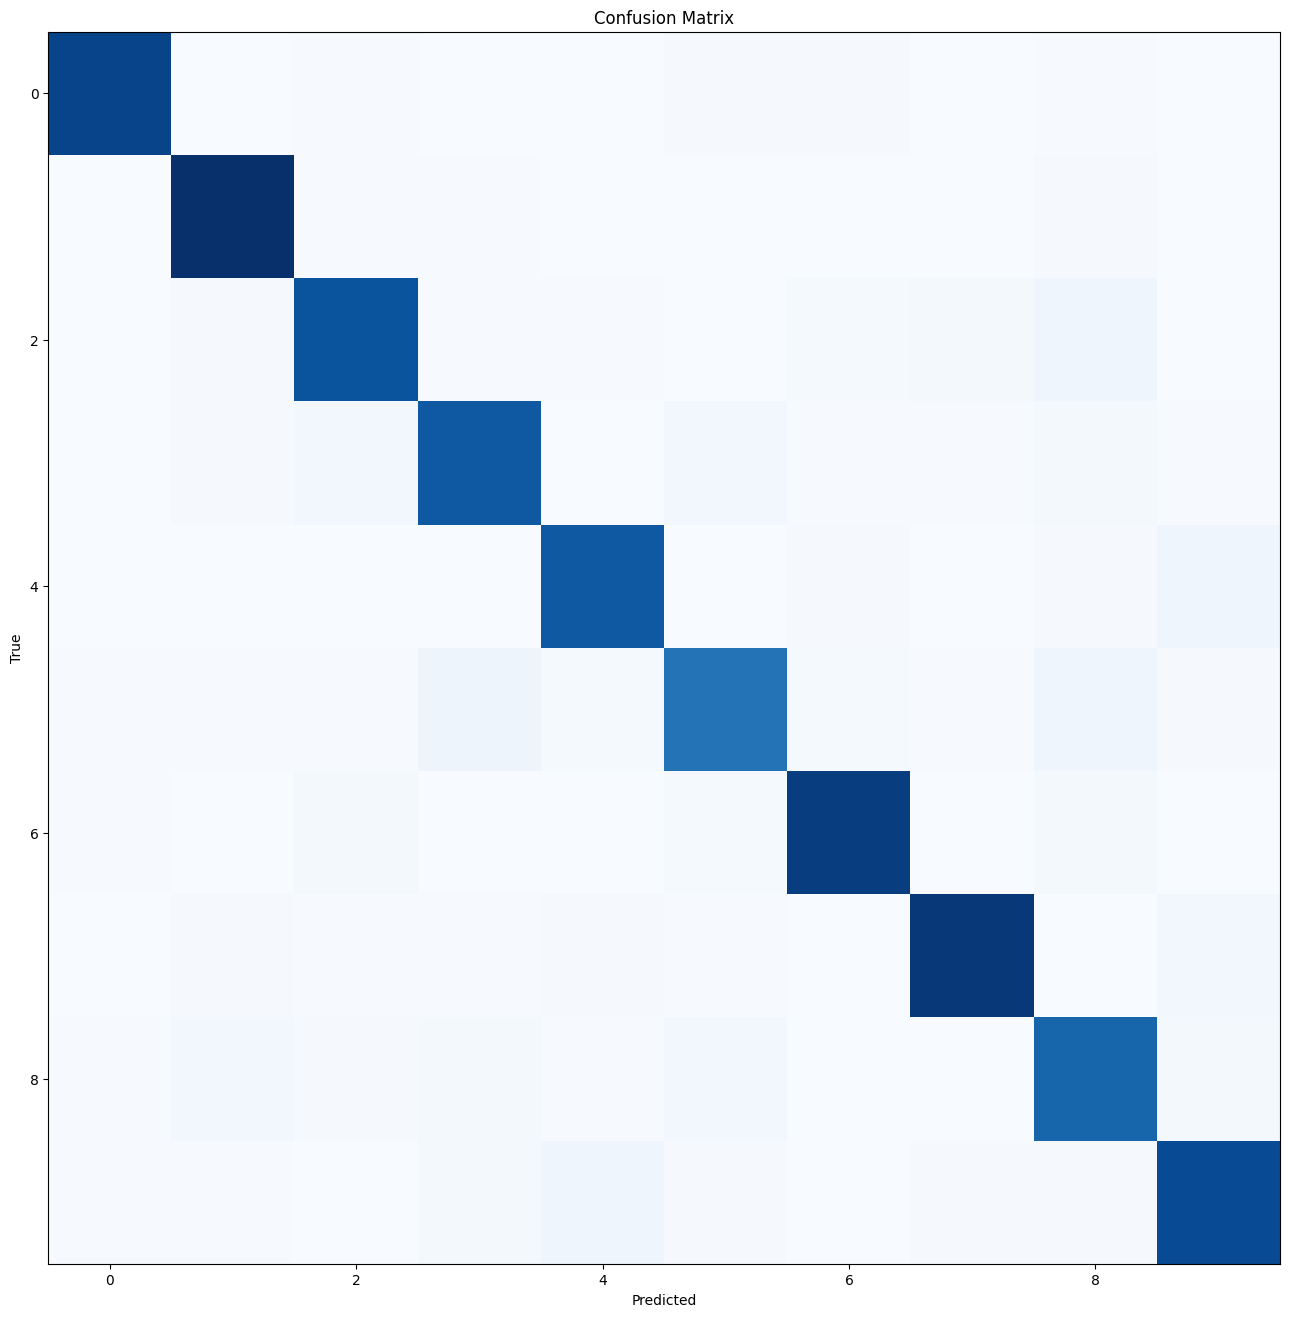

In [223]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

figure = plt.figure(figsize=(16, 16))

ax = figure.add_subplot(1, 1, 1)

ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

plt.show()